A quick pipeline I put together for Kaggle's "Getting Started" competition - [Titanic: Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic/overview).
It includes:


1.   EDA
2.   Feature imputation via k-Nearest-Neighbours
3.   Feature generation
4.   Feature scaling
5.   Modeling via     






    ('Logistic Regression', LogisticRegression(n_jobs=num_jobs)),
    ('Random Forest', RandomForestClassifier(n_jobs=num_jobs)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('XGBoost', XGBClassifier(booster='gbtree', n_jobs=num_jobs)),
    ('SVM', SVC()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('SGD', SGDClassifier(n_jobs=num_jobs))

6.   Cross-validated feature selection via feature importance
7.   Cross-validated hyperparameter tuning via

  a. Bayesian optimization via HyperOpt

  b. Grid Search
8.   Ensambling via

  a. Voting classifier

  b. Stacking with a Logistic Regression meta-learner


Next TODOs for someone looking to improve this would be:
*   Analyze the features of those we misclassify, look for something we can adress with existing features/engineer new ones
*   More extensive hyperparamsearch



#Imports

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, Trials, STATUS_OK, space_eval
import warnings

#Exploratory Data Analysis (EDA)

Data dictionary as provided [here](https://www.kaggle.com/competitions/titanic/data)

| Variable | Definition | Key | My remarks |
| --- | --- | --- | --- |
|survival|Survival|"0 = No, 1 = Yes"| Our target variable, since it is a binary categorical variable, good model candidates are: Logistic regression, Decision trees (Random forests, gradient boosted, XGBoost, etc.)
pclass|Ticket class|"1 = 1st, 2 = 2nd, 3 = 3rd"|Ordinal variable, 1>2>3
sex|Sex||Binary categorical variable
Age|Age in years||Continious variable
sibsp|# of siblings / spouses aboard the Titanic|| Discrete variable
parch|# of parents / children aboard the Titanic|| Discrete variable
ticket|Ticket number|| Not quite the same as a PassengerId, since passengers could share tickets
fare|Passenger fare|| Continious, might overlap with Pclass?
cabin|Cabin number|| Could be interesting to model distance from wreckage site
embarked|Port of Embarkation|"C = Cherbourg, Q = Queenstown, S = Southampton"|Categorical variable
PassengerId |Unique ID of Passenger||Does not seem too useful, as we are not interested in modeling individual random effects, can be dropped

##Import data

With the note that we will only use the test dataset for predictions and our completeness check in the beginning, and never for our models or even during the rest of our EDA.

In [61]:
train = pd.read_csv("/content/drive/MyDrive/Kaggle/titanic/train.csv") # Substitute with your own data path
test = pd.read_csv("/content/drive/MyDrive/Kaggle/titanic/test.csv") # Substitute with your own data path
dataset = pd.concat([train, test])

##Check for completeness

Check number of entries and features

In [62]:
print("Training set shape:", train.shape)
print("Test set shape:", test.shape)
print("Total entries of combined dataset:", dataset.shape[0])

Training set shape: (891, 12)
Test set shape: (418, 11)
Total entries of combined dataset: 1309


Check which feature is present in train set and missing from test set

In [63]:
train.columns[~train.columns.isin(test.columns)]

Index(['Survived'], dtype='object')

Logically, it is the target variable, "Survived" - i.e., our test set only provides the features we will later use to compute the predictions for our submission, we will only know our final test accuracy after submitting.

Get missing data relative to our whole train dataset

In [64]:
print(train.isnull().sum()/train.shape[0])
print(test.isnull().sum()/test.shape[0])

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64
PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64


Notes

*   We are missing around 20% of our Age entries
*   We are missing over 75% of our Cabin entries
*   We are missing a few Embarked and Fare entries
*   Depending on the models we use, we may need to impute or delete missing entries later, as not all models have built-in missing data measures








##Univariate feature analysis

In [65]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Main finding:
*   38.8% of the passengers survived - therefore the data is not too unbalanced (the least morbid way to look at things)



Now let us take a look at the relationship of survival with each individual variable.

In [66]:
def plot_categorical_features(df, feature_names):
    # Set up the number of rows and columns for subplots
    num_features = len(feature_names)
    num_cols = 2  # Adjust the number of columns for subplots as desired
    num_rows = (num_features + num_cols - 1) // num_cols
    plt.figure(figsize=(15, 10))  # Set the overall figure size

    # Loop through each feature and create a subplot for each
    for i, feature in enumerate(feature_names, start=1):
        plt.subplot(num_rows, num_cols, i)

        # Calculate survival rate for each category of the feature
        survival_rate = df.groupby(feature)['Survived'].mean().sort_values(ascending=True)

        # Plotting the survival rate for each category of the feature
        sns.barplot(x=survival_rate.index, y=survival_rate.values)
        plt.title(f"Survival Rate by {feature}")
        plt.xlabel(feature)
        plt.ylabel("Survival Rate")
        plt.tight_layout()

    plt.show()

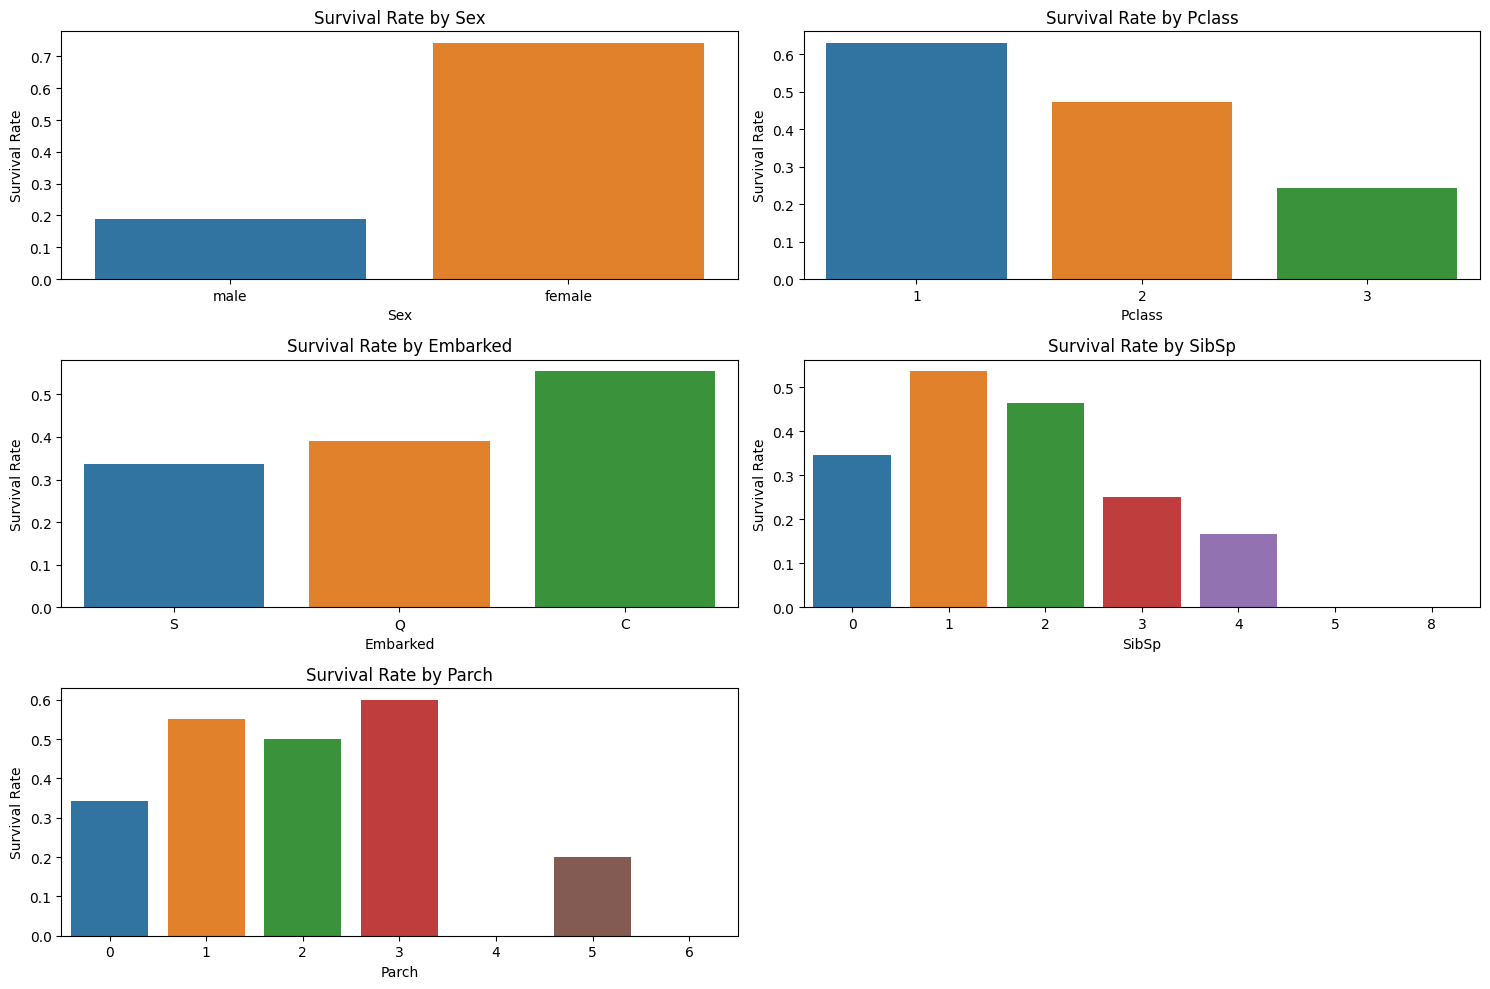

In [67]:
plot_categorical_features(train, ["Sex", "Pclass", "Embarked", "SibSp", "Parch"])

Initial takeaways:
*   Sex appears to have had a crucial effect on survival, the average female was much more likely to survive than the average male - makes sense as the survival of women is usually prioritized in crisis situations ("women and children first")
*   Passenger class also seems to have played an important part in survival, the higher the class (in the sense of first class being the highest), the better the odds of survival
*   Embarking on the Titanic in port "C" - Cherbourg - appears to increase survival odds, not immediately obvious why. First idea: perhaps tickets from Cherbourg were more expensive/more of them belonged to a higher passenger class, so this effect would potentially be correlated with PClass.
*   Having family on board appears to have helped survival odds - up to a point - makes sense as families would look after each other in a crisis situation.





In [68]:
def plot_continuous_features(df, feature_names):
    plt.figure(figsize=(12, 5))  # Set the figure size

    # Loop through each feature and create histograms for survivors and non-survivors
    for i, feature in enumerate(feature_names, start=1):
        plt.subplot(1, len(feature_names), i)

        # Calculate the number of bins for both survivors and non-survivors
        bins_survived = max(20, len(pd.unique(df[df['Survived'] == 1][feature])))
        bins_not_survived = max(20, len(pd.unique(df[df['Survived'] == 0][feature])))
        bins = max(bins_survived, bins_not_survived)

        # Plotting histograms for survivors and non-survivors with the same bin width
        sns.histplot(df[df['Survived'] == 1][feature], bins=bins, color='blue', label='Survived', alpha=0.5)
        sns.histplot(df[df['Survived'] == 0][feature], bins=bins, color='salmon', label='Deceased', alpha=0.5)

        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()


    plt.show()

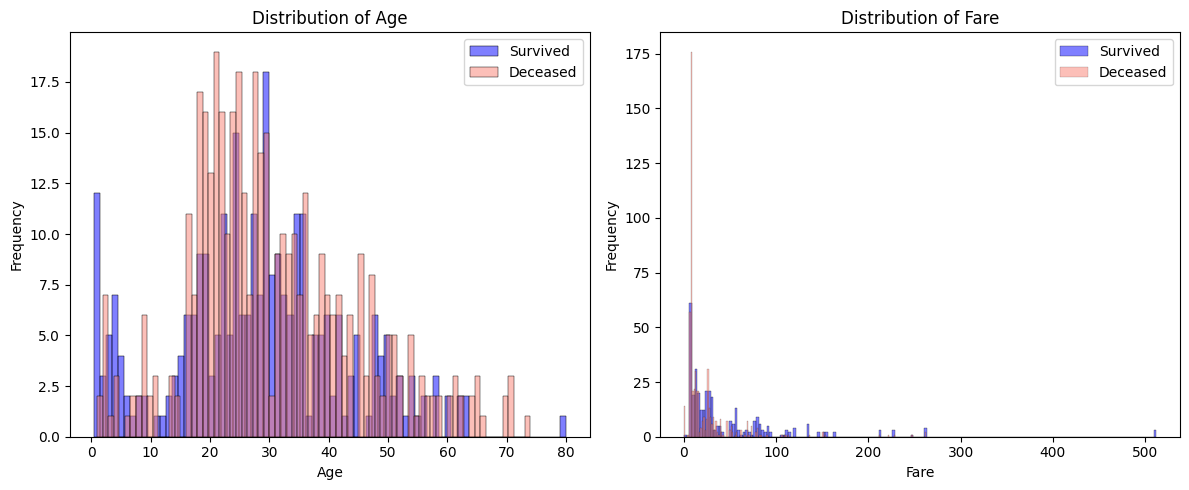

In [69]:
plot_continuous_features(train, ['Age', 'Fare'])

Let us try and use a kernel density estimation plot instead for a clearer view

In [70]:
def plot_continuous_features_kde(df, feature_names):
    plt.figure(figsize=(12, 5))  # Set the figure size

    # Loop through each feature and create KDE plots for survivors and non-survivors
    for i, feature in enumerate(feature_names, start=1):
        plt.subplot(1, len(feature_names), i)

        # Plotting kernel density plots for survivors and non-survivors using Seaborn
        sns.kdeplot(df[df['Survived'] == 1][feature], fill=True, color='blue', label='Survived')
        sns.kdeplot(df[df['Survived'] == 0][feature], fill=True, color='salmon', label='Deceased')
        plt.xlim(0,df[feature].max())
        plt.title(f"Kernel Density Estimation of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()

    plt.show()

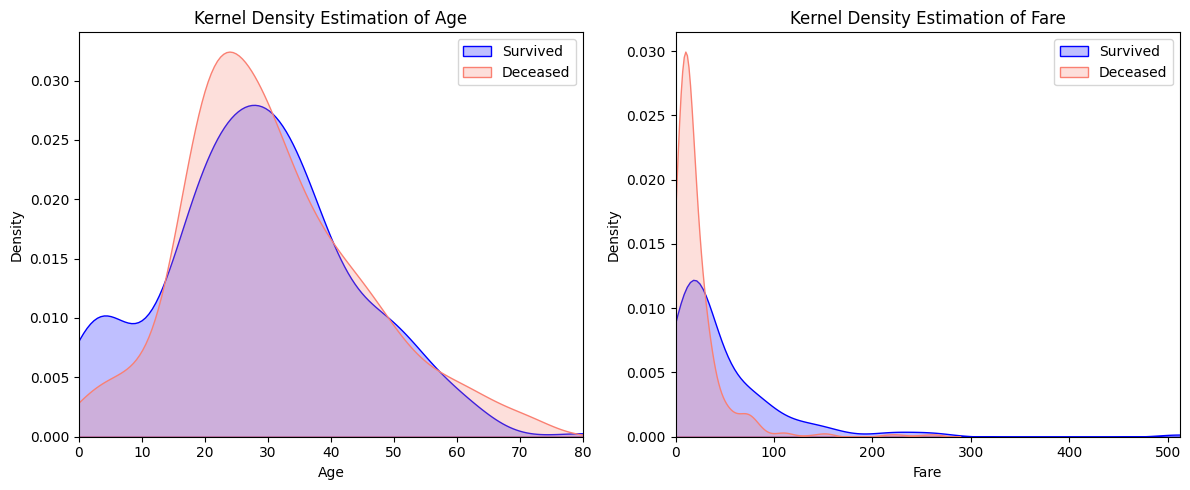

In [71]:
plot_continuous_features_kde(train, ['Age', 'Fare'])

Initial takeaways:
*   Children ~13 and under appear to be likelier to survive - makes sense as
 the survival of children is usually prioritized in crisis situations
*   People in their 20s were substantially less likely to survive - an initial guess could be that they are too old to be considered a priority for lifeboats, but also too young to be able to afford a higher class ticket on their own
*   Paying a higher fare (which almost surely buys a higher class ticket) also appears to offer better odds of survival


##Multivariate feature analysis

Now that we have established some foundational notion of the individual relationships between the variables and our target, survivability, it is worth it to also consider their interplay.

<Axes: >

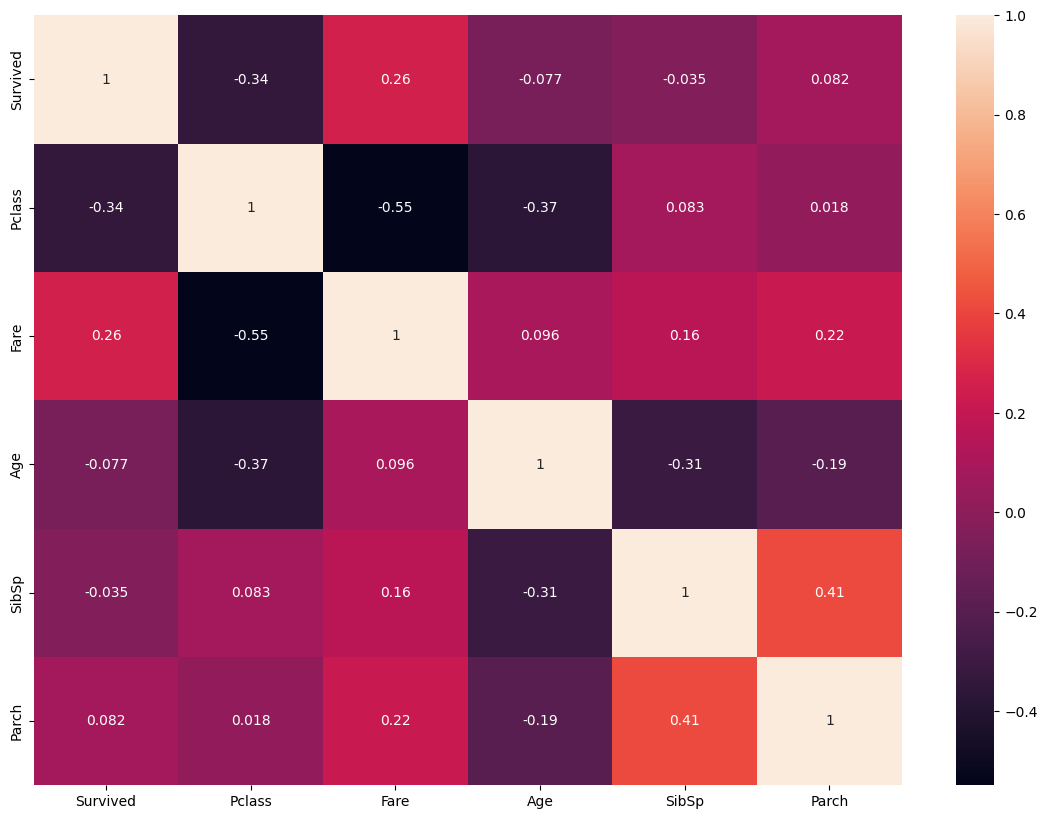

In [72]:
features = ["Survived","Pclass","Fare","Age","SibSp","Parch"]

plt.figure(figsize=(14,10))
sns.heatmap(train[np.isfinite(train["Survived"])][features].corr(), annot = True)

Remarks:
*   Logically, Pclass and Fare have considerable negative(remember Pclass is ordinal with 1>2>3, hence the negativeness) correlation, as a more expensive fare should directly secure a higher-class ticket.
*   Age and Pclass also exhibit a noteworthy negative correlation, which validates our earlier musings that younger travellers may have been less able to afford a more expensive ticket.
*   Despite the fact that an increase in Age correlates with a higher Pclass (which in its own right correlates with an increase of survival probability), it is overall negatively correlated with survival probability. As we saw earlier, children under 13 were considerably more likely to survive than anyone else, which somewhat skews the variable. It is therefore almost certainly a good idea to transform the age variable into a categorical one to more accurately model the obvious non-linearity.
*   SibSp and Parch - the number of siblings/spouses and the number of parents/children aboard exhibit noteworthy positive correlation - this makes a lot of sense, since having ones children on board seems a lot likelier when one also has his spouse.(and vice versa).






TLDR:
*   Pclass and Fare may be redundant, be on the lookout when feature generating/selecting
*   Age may be worth splitting into bins since its effect on survival probability seems non-linear
*   SibSp and Parch may be worth combining into a single feature



#Pre-processing

Whenever we drop, impute, generate or normalize features in the next steps, we will be repeating the process for the test set. It is crucial however that the two are always separate, and that we do not let the train and test sets "talk" - i.e. we should not let the test data inform us about the scaling and generation of features in the train data and vice versa.

At this stage we will be dropping the PassengerId variable, as is irrelevant to our modeling goals.

In [73]:
train = train.drop(['PassengerId'], axis = 1)
test_PassengerId = test["PassengerId"] #Will need that for our submission later
test = test.drop(['PassengerId'], axis = 1)

## Imputing/deleting missing data

###Cabin

As outlined earlier, we are missing over 75% of our Cabin entries. Generally, this means imputation would introduce too much conjecture in our dataset. Moreover, the variable manifests as "Character(representing Deck)Number(representing room number)" - we could maybe derive strategies to impute the deck based on passenger class, but the number would be pure guesswork.

In [74]:
train["Cabin"][~train["Cabin"].isnull()].values

array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73',
       'C23 C25 C27', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60',
       'E101', 'D26', 'F E69', 'D47', 'C123', 'B86', 'F2', 'C2', 'E33',
       'B19', 'A7', 'C49', 'F4', 'A32', 'F2', 'B4', 'B80', 'G6', 'A31',
       'D36', 'D15', 'C93', 'C83', 'C78', 'D35', 'G6', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'B58 B60', 'E101', 'C22 C26', 'C65', 'E36',
       'C54', 'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'D', 'B18', 'C124',
       'C91', 'C2', 'E40', 'T', 'F2', 'C23 C25 C27', 'F33', 'C128', 'E33',
       'D37', 'B35', 'E50', 'C82', 'B96 B98', 'D36', 'G6', 'C78', 'E10',
       'C52', 'E44', 'B96 B98', 'C23 C25 C27', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'D', 'A14', 'B49', 'C93', 'B37',
       'C30', 'D20', 'C22 C26', 'B79', 'C65', 'E25', 'D46', 'F33', 'B73',


And in fact even deriving deck based on passenger class would be close to impossible without using external data, as

In [75]:
for i in set(train.Pclass.values):
  print(f"Passenger class {i} has","{:.2%}".format(train[train.Pclass==i]["Cabin"].isnull().sum()/train[train.Pclass==i].shape[0]),"of its cabin data missing.")

Passenger class 1 has 18.52% of its cabin data missing.
Passenger class 2 has 91.30% of its cabin data missing.
Passenger class 3 has 97.56% of its cabin data missing.


cabin data only seems to have been recorded for first class passengers. Therefore, we will be deleting the variable altogether.

In [76]:
train = train.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

###Age

As outlined earlier, we are missing roughly 20% of our Age entries. Therefore, imputation could be a reasonable step. Failing to find reasonable imputation criteria, we may instead remove entries with missing data. Deleting the entire variable like we did with Cabin is out of the question, as Age seemed to be a promising predictive factor towards survivability, as shown earlier.
Morevore, since we earlier postulated that Age may have a non-linear effect on survivability and we intend to translate it into categorical bins, we can get away with imperfect imputations.


Let us first check whether the age data is systematically or randomly missing.

In [77]:
for i in set(train.Pclass.values):
  print(f"Passenger class {i} has","{:.2%}".format(train[train.Pclass==i]["Age"].isnull().sum()/train[train.Pclass==i].shape[0]),"of its age data missing.")

Passenger class 1 has 13.89% of its age data missing.
Passenger class 2 has 5.98% of its age data missing.
Passenger class 3 has 27.70% of its age data missing.


In [78]:
for i in set(train.Sex.values):
  print(f"Passenger sex {i} has","{:.2%}".format(train[train.Sex==i]["Age"].isnull().sum()/train[train.Sex==i].shape[0]),"of its age data missing.")

Passenger sex female has 16.88% of its age data missing.
Passenger sex male has 21.49% of its age data missing.



One common imputation technique is k-Nearest-Neighbours. However, that will only take into account our numerical data (and data we can convert to numerical via dummies) - so let us first try to gain what insight we can from our nominal data.

One clue towards imputing age could be to infer titles from names - perhaps some titles can help us get a rough range for the age of the person.

In [79]:
train['Surname'] = train['Name'].str.split(', ', expand=True)[0]
train['Title'] =  train['Name'].str.split(', ', expand=True)[1].str.split('. ', expand=True)[0]
test['Surname'] = test['Name'].str.split(', ', expand=True)[0]
test['Title'] =  test['Name'].str.split(', ', expand=True)[1].str.split('. ', expand=True)[0]

Check the title distribution of passengers with missing Age entries

In [80]:
print(train[train['Age'].isnull()]['Title'].value_counts())
print(test[test['Age'].isnull()]['Title'].value_counts())

Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: Title, dtype: int64
Mr        57
Miss      14
Mrs       10
Master     4
Ms         1
Name: Title, dtype: int64


Get the Age descriptive statistics of passengers conditioned on their title

In [81]:
# Create an empty dictionary to store descriptive statistics for each title
train_title_descriptive_stats = {}
test_title_descriptive_stats = {}

# Iterate through unique titles and store descriptive statistics in the dictionary
for i in set(train['Title'].values):
    train_title_stats = train[train['Title'] == i]['Age'].describe()  # Compute descriptive statistics
    train_title_descriptive_stats[i] = train_title_stats  # Store the statistics in the dictionary
for i in set(test['Title'].values):
    test_title_stats = test[test['Title'] == i]['Age'].describe()  # Compute descriptive statistics
    test_title_descriptive_stats[i] = test_title_stats  # Store the statistics in the dictionary

# Convert the dictionary into a DataFrame
train_descriptive_stats_df = pd.DataFrame(train_title_descriptive_stats)
test_descriptive_stats_df = pd.DataFrame(test_title_descriptive_stats)

Take a look at titles for which we have missing age entries

In [82]:
print(train_descriptive_stats_df[train[train['Age'].isnull()]['Title'].value_counts().index.tolist()].transpose())
print(test_descriptive_stats_df[test[test['Age'].isnull()]['Title'].value_counts().index.tolist()].transpose())

        count       mean        std    min     25%   50%    75%   max
Mr      398.0  32.368090  12.708793  11.00  23.000  30.0  39.00  80.0
Miss    146.0  21.773973  12.990292   0.75  14.125  21.0  30.00  63.0
Mrs     108.0  35.898148  11.433628  14.00  27.750  35.0  44.00  63.0
Master   36.0   4.574167   3.619872   0.42   1.000   3.5   8.00  12.0
Dr        6.0  42.000000  12.016655  23.00  35.000  46.5  49.75  54.0
        count       mean        std    min    25%   50%    75%   max
Mr      183.0  32.000000  11.804497  14.00  23.00  28.5  40.00  67.0
Miss     64.0  21.774844  10.457716   0.17  17.75  22.0  29.25  45.0
Mrs      62.0  38.903226  15.034070  16.00  26.00  36.5  49.50  76.0
Master   17.0   7.406471   4.672470   0.33   5.00   7.0  11.50  14.5
Ms        0.0        NaN        NaN    NaN    NaN   NaN    NaN   NaN


Main takeaways:
*   Of the 36 passengers with the title "Master" (a male title), none are older than 12 years (14.5 in the test set), indicating that this is a title for boys.
*   "Miss" does not give us any useful information, as it has been used for infants and adult women alike
*   The titles "Mr" and "Mrs" seem to rule out that the passenger is a child, but not much else
*   Dr being an occupation logically means that the person must be atleast in their 20s





Therefore, we can feel rather secure in imputing the mean Master age for those with title Master

In [83]:
train_mean_master_age = train[train['Title'] == 'Master']['Age'].mean()
train.loc[(train['Age'].isnull()) & (train['Title'] == "Master"), 'Age'] = train_mean_master_age
test_mean_master_age = test[test['Title'] == 'Master']['Age'].mean()
test.loc[(test['Age'].isnull()) & (test['Title'] == "Master"), 'Age'] = test_mean_master_age

### Fare and Embarked

Recall we are also missing 2 Embarked entries in the train set, and 1 Fare entry in the test set. We will also be imputing those away via the KNNimputer.

In [84]:
print(train.isnull().sum())
print(test.isnull().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         173
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
Surname       0
Title         0
dtype: int64
Pclass       0
Name         0
Sex          0
Age         82
SibSp        0
Parch        0
Ticket       0
Fare         1
Embarked     0
Surname      0
Title        0
dtype: int64


###KNNImputer

Since the KNNImputer only deals with numerical data, we need to add dummy variables for our previously nominal categorical data. In doing so, we will also be dropping the variables "Name" and "Ticket", as well as the newly generated "Surname" and "Title"

 We make sure to not include Survived as we want to avoid using it to predict Age (as we will later use Age to predict Survived)

In [85]:
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
y_train = train["Survived"]
train_dummy = pd.get_dummies(train[features])
test_dummy = pd.get_dummies(test[features])

Keep track of indices of missing Age entries

In [86]:
train_missing_ind = train_dummy[train_dummy["Age"].isnull()].index
test_missing_ind = test_dummy[test_dummy["Age"].isnull()].index

In [87]:
knn_imputer = KNNImputer(n_neighbors=5)
train_imputed_data = knn_imputer.fit_transform(train_dummy)
test_imputed_data = knn_imputer.fit_transform(test_dummy)
train_knnimputed = pd.DataFrame(train_imputed_data, columns = train_dummy.columns)
test_knnimputed = pd.DataFrame(test_imputed_data, columns = train_dummy.columns)

#Feature generation


Recall that our KNNImputer could only take numerical data, meaning we had to temporarily remove some of our features - the nominal features Name, Surname, Title, as well as Ticket.

We reason that we may not need to bring them back in - since we still need a numerical way to represent them, or, alternatively, generate some other numerical features throught them.

*   Name in its entirety can basically serve as a PassengerId and is thus useless.
*   Surname can be useful - it can point us to people who are related - but a lot of family relations are already covered by the variables Parch and SibSp.
*   In principle, Title appears as a potentially useful variable - in fact we already used it to help us impute Age. However, it can be argued that it is effectively a proxy for Sex, Age and perhaps even Pclass/Fare since it can also show social standing. Further, it has way too many individual values to be able to meaningfully one-hot-encode, and it is not cardinal or ordinal in a way which can make sense numerically. Therefore, we chose to omit it from future analysis.
*   Ticket is not completely useless as it may initially seem, since it appears it is not unique - it seems people could share tickets. Which begs the question, are the ticket fares then reflective of the entire ticket price, or have they been adjusted to show how much the individual fare was worth? For our model, we would rather it be the latter, since the former would bias Fares towards bigger groups. Let us check it out:



In [88]:
# Identify unique and group tickets
train_ticket_counts = train['Ticket'].value_counts()
train_group_tickets = train_ticket_counts[train_ticket_counts > 1].index
train_unique_tickets = train_ticket_counts[train_ticket_counts == 1].index

test_ticket_counts = test['Ticket'].value_counts()
test_group_tickets = test_ticket_counts[test_ticket_counts > 1].index
test_unique_tickets = test_ticket_counts[test_ticket_counts == 1].index

# Split the dataset
group_data = train[train['Ticket'].isin(train_group_tickets)]
unique_data = train[train['Ticket'].isin(train_unique_tickets)]

# Calculate average fares for group tickets
group_avg_fares = group_data.groupby('Pclass')['Fare'].mean()

# Calculate average fares for unique tickets
unique_avg_fares = unique_data.groupby('Pclass')['Fare'].mean()

# Calculate individual fares for group tickets
group_data = group_data.copy()
group_data['Individual_Fare'] = group_data.groupby('Ticket')['Fare'].transform(lambda x: x / x.count())
group_individual_avg_fares = group_data.groupby('Pclass')['Individual_Fare'].mean()

# Combine the results
comparison = pd.DataFrame({
    'Avg fare for group tickets': group_avg_fares,
    'Avg fare for individual tickets': unique_avg_fares,
    'Avg fare for group tickets adjusted for group size': group_individual_avg_fares
})

comparison

,Avg fare for group tickets,Avg fare for individual tickets,Avg fare for group tickets adjusted for group size
Pclass,,,
1,120.210785,39.920919,46.690302
2,29.621917,14.214524,12.083171
3,25.770719,8.456643,7.226534


The average fare for group tickets seems to be 2-3x higher than for unique tickets of the same passenger class.
It appears likely then that the fare for group tickets was not adjusted to account for the size of the group, thus inflating the Fare variable for individuals that happen to be travelling in groups. We will move to adjust it so that it can more accurately represent the fare that the individual actually would have paid.

In [89]:
# For group tickets, divide the fare by the number of people sharing the ticket
for ticket in train_group_tickets:
    group_size = train_ticket_counts[ticket]
    train_knnimputed.loc[train['Ticket'] == ticket, 'Individual_Fare'] = train['Fare'] / group_size
for ticket in test_group_tickets:
    group_size = test_ticket_counts[ticket]
    test_knnimputed.loc[test['Ticket'] == ticket, 'Individual_Fare'] = test_knnimputed['Fare'] / group_size

# For unique tickets, individual fare is the same as the total fare
for ticket in train_unique_tickets:
    train_knnimputed.loc[train['Ticket'] == ticket, 'Individual_Fare'] = train.loc[train['Ticket'] == ticket, 'Fare']
for ticket in test_unique_tickets:
    test_knnimputed.loc[test['Ticket'] == ticket, 'Individual_Fare'] = test_knnimputed.loc[test['Ticket'] == ticket, 'Fare']

At this stage, we can generate some further features that seem potentially helpful for our prediction efforts. We do not need to worry about overfitting through too many features quite yet, as we will later perform feature selection anyway.

First, we can combine the number of parents/children and siblings/spouses one has on board to a new variable, Fam(ily)Size

In [90]:
# Create a new column as a sum of listed relatives
train_knnimputed['FamSize'] = train_knnimputed['Parch'] + train_knnimputed['SibSp'] + 1  # plus one to include the passenger
test_knnimputed['FamSize'] = test_knnimputed['Parch'] + test_knnimputed['SibSp'] + 1

Next, recall we considered that the interplay between age and survivability may be non-linear - thus we can try categorizing age into different bins.

In [91]:
bin_thresholds = [0, 15, 30, 40, 59, 90]
bin_labels = ['0-15', '16-29', '30-40', '41-59', '60+']
train_knnimputed['AgeBin'] = pd.cut(train_knnimputed['Age'], bins=bin_thresholds, labels=bin_labels)
test_knnimputed['AgeBin'] = pd.cut(test_knnimputed['Age'], bins=bin_thresholds, labels=bin_labels)

#Feature normalization

In [97]:
train_knnimputed.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Individual_Fare', 'FamSize',
       'AgeBin'],
      dtype='object')

As a final step before commencing the actual modeling, we will scale our continious variables and dummy code the remaining ordinal and categorical data, since some machine learning models and especially those using gradient descent are not scale-invariant.



Dummy code all our categorical data

In [98]:
train_knnimputed["Pclass"] = train_knnimputed["Pclass"].astype("category")
test_knnimputed["Pclass"] = test_knnimputed["Pclass"].astype("category")
train_knnimputed_dummy = pd.get_dummies(train_knnimputed)
test_knnimputed_dummy = pd.get_dummies(test_knnimputed)

Scale our continious variables

In [99]:
scaler = MinMaxScaler()
cont_features = ["Fare","Age","Parch","SibSp","FamSize","Individual_Fare"]
train_knnimputed_dummy[cont_features] = pd.DataFrame(scaler.fit_transform(train_knnimputed_dummy[cont_features]))
test_knnimputed_dummy[cont_features] = pd.DataFrame(scaler.fit_transform(test_knnimputed_dummy[cont_features]))

In [100]:
train_knnimputed_dummy

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Individual_Fare,FamSize,Pclass_1.0,Pclass_2.0,Pclass_3.0,AgeBin_0-15,AgeBin_16-29,AgeBin_30-40,AgeBin_41-59,AgeBin_60+
0,0.271174,0.125,0.000000,0.014151,0.0,1.0,0.0,0.0,1.0,0.032690,0.1,0,0,1,0,1,0,0,0
1,0.472229,0.125,0.000000,0.139136,1.0,0.0,1.0,0.0,0.0,0.321416,0.1,1,0,0,0,0,1,0,0
2,0.321438,0.000,0.000000,0.015469,1.0,0.0,0.0,0.0,1.0,0.035734,0.0,0,0,1,0,1,0,0,0
3,0.434531,0.125,0.000000,0.103644,1.0,0.0,0.0,0.0,1.0,0.119714,0.1,1,0,0,0,0,1,0,0
4,0.434531,0.000,0.000000,0.015713,0.0,1.0,0.0,0.0,1.0,0.036297,0.0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.334004,0.000,0.000000,0.025374,0.0,1.0,0.0,0.0,1.0,0.058617,0.0,0,1,0,0,1,0,0,0
887,0.233476,0.000,0.000000,0.058556,1.0,0.0,0.0,0.0,1.0,0.135270,0.0,1,0,0,0,1,0,0,0
888,0.251068,0.125,0.333333,0.045771,1.0,0.0,0.0,0.0,1.0,0.052868,0.3,0,0,1,0,1,0,0,0
889,0.321438,0.000,0.000000,0.058556,0.0,1.0,1.0,0.0,0.0,0.135270,0.0,1,0,0,0,1,0,0,0


Drop Sex_male dummy variable since it is already fully implied by Sex_female. I come from a Statistics background where this is common - for the tree-based approaches we later use, this is mostly useless,
I am generally used to removing one category per dummy variable (since it is by definition implied by the absence of the rest, but apparently

In [101]:
train_knnimputed_dummy.drop(["Sex_male", "Embarked_Q", "Pclass_3.0", "AgeBin_60+"], axis = 1, inplace = True)
test_knnimputed_dummy.drop(["Sex_male", "Embarked_Q", "Pclass_3.0", "AgeBin_60+"], axis = 1, inplace = True)

#Modeling

##Initial implementation

In [102]:
train_knnimputed_dummy.columns.values

array(['Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Embarked_C',
       'Embarked_S', 'Individual_Fare', 'FamSize', 'Pclass_1.0',
       'Pclass_2.0', 'AgeBin_0-15', 'AgeBin_16-29', 'AgeBin_30-40',
       'AgeBin_41-59'], dtype=object)

In [ ]:
def evaluate_models(X_train, y_train, models, random_state = 41):
    results = []
    feature_importance_list = []  # List to store feature importance data

    # Perform cross-validation for each model
    for model_name, model in models:
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = random_state)
        train_accuracies = []
        val_accuracies = []
        fold_feature_importances = []
        #print(skf)
        for train_index, val_index in skf.split(X_train, y_train):
          X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
          y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
          #print(train_index)
          #print(val_index)

          model.fit(X_train_fold, y_train_fold)

          # Calculate training accuracy
          train_accuracy = accuracy_score(y_train_fold, model.predict(X_train_fold))
          train_accuracies.append(train_accuracy)

          # Calculate validation accuracy
          val_accuracy = accuracy_score(y_val_fold, model.predict(X_val_fold))
          val_accuracies.append(val_accuracy)
          if hasattr(model, 'feature_importances_'):
                fold_feature_importances.append(model.feature_importances_)

        mean_train_accuracy = np.mean(train_accuracies)
        mean_val_accuracy = np.mean(val_accuracies)
        std_train_accuracy = np.std(train_accuracies)
        std_val_accuracy = np.std(val_accuracies)

        if fold_feature_importances:
            mean_feature_importance = np.mean(fold_feature_importances, axis=0)
            feature_importance_list.append({
                'Model': model_name,
                'Mean Feature Importance': mean_feature_importance,
                'Feature Names': X_train.columns.tolist()
            })

        results.append({
            'Model': model_name,
            'Mean Train Accuracy': mean_train_accuracy,
            'Train Accuracy Std': std_train_accuracy,
            'Mean Validation Accuracy': mean_val_accuracy,
            'Validation Accuracy Std': std_val_accuracy
        })

    # Create DataFrame of results
    results_df = pd.DataFrame(results)
    feature_importance_df = pd.DataFrame(feature_importance_list)
    return results_df, feature_importance_df

In [ ]:
num_jobs = -1

models = [
    ('Logistic Regression', LogisticRegression(n_jobs=num_jobs)),
    ('Random Forest', RandomForestClassifier(n_jobs=num_jobs)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('XGBoost', XGBClassifier(booster='gbtree', n_jobs=num_jobs)),
    ('SVM', SVC()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('SGD', SGDClassifier(n_jobs=num_jobs))
]

X_train = train_knnimputed_dummy.drop(['Age',"Fare"], axis=1) #drop continious Age and non-adjusted Fare
X_test = test_knnimputed_dummy.drop(['Age',"Fare"], axis=1) #drop continious Age and non-adjusted Fare
y_train = y_train

initial_results_df, feature_importance_df = evaluate_models(X_train, y_train, models)

In [ ]:
initial_results_df

,Model,Mean Train Accuracy,Train Accuracy Std,Mean Validation Accuracy,Validation Accuracy Std
0,Logistic Regression,0.811199,0.006835,0.799151,0.042778
1,Random Forest,0.946877,0.001770,0.795855,0.041678
2,Decision Tree,0.946877,0.001770,0.798052,0.038738
3,XGBoost,0.937648,0.001463,0.813783,0.038354
4,SVM,0.834893,0.007051,0.823895,0.040782
5,Gradient Boosting,0.889015,0.006233,0.830662,0.048286
6,SGD,0.792621,0.028538,0.784582,0.048255


While our validation accuracies are by no means bad for a non-tuned model, some models overfit on the training data to the tune of a 15% train-val accuracy gap - we will need to enact some measures to ensure our models are able to generalize well.

##Feature selection

One such measure is feature selection, in which we try to identify which features are actually meaningful for our prediction goals, and which generate unneeded fluff that mostly serves to overfit our models.

In [ ]:
# Function to plot descending feature importance for each model
def plot_feature_importance(feature_importance_df):
    for _, row in feature_importance_df.iterrows():
        model_name = row['Model']
        feature_importance = row['Mean Feature Importance']
        feature_names = row['Feature Names']

        if feature_importance is not None:
            sorted_indices = np.argsort(feature_importance)[::-1]
            sorted_feature_importance = feature_importance[sorted_indices]
            sorted_feature_names = [feature_names[i] for i in sorted_indices]

            plt.figure(figsize=(16, 6))
            plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance)
            plt.title(f'{model_name} Feature Importance')
            plt.xlabel('Feature')
            plt.ylabel('Importance')
            plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation=90)
            plt.tight_layout()
            plt.show()

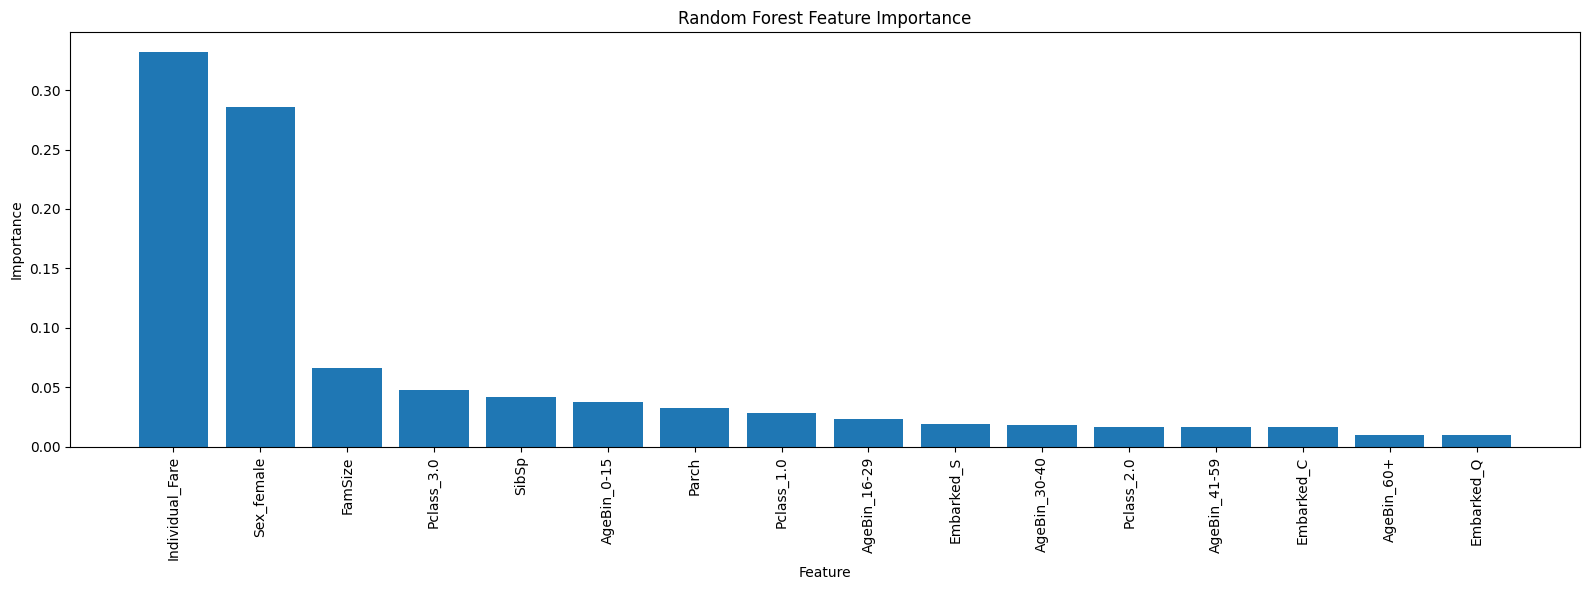

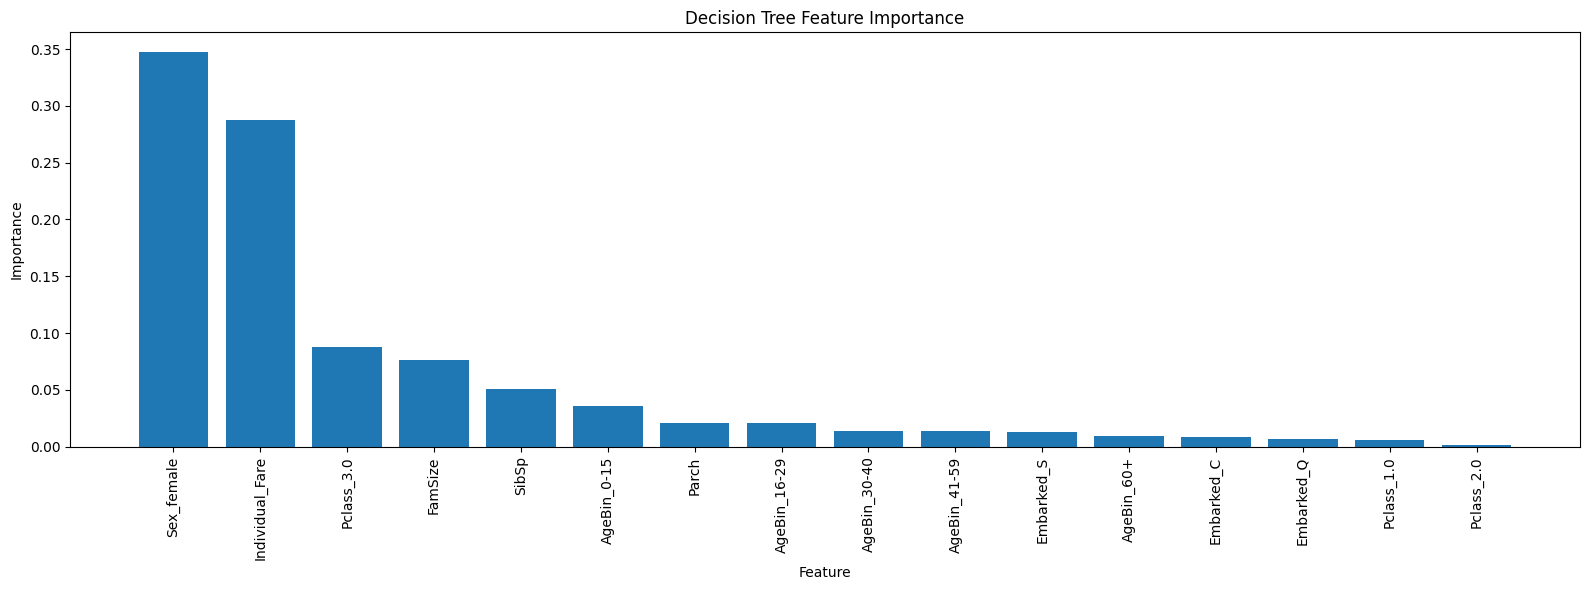

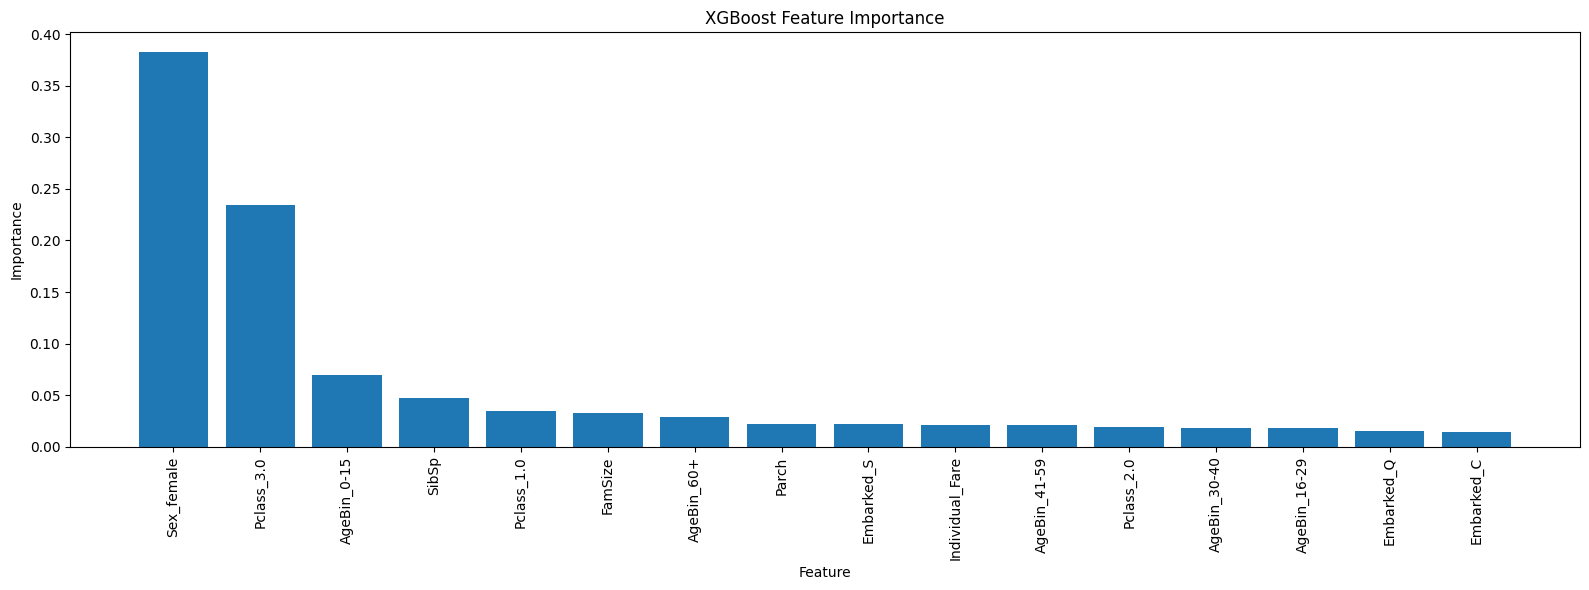

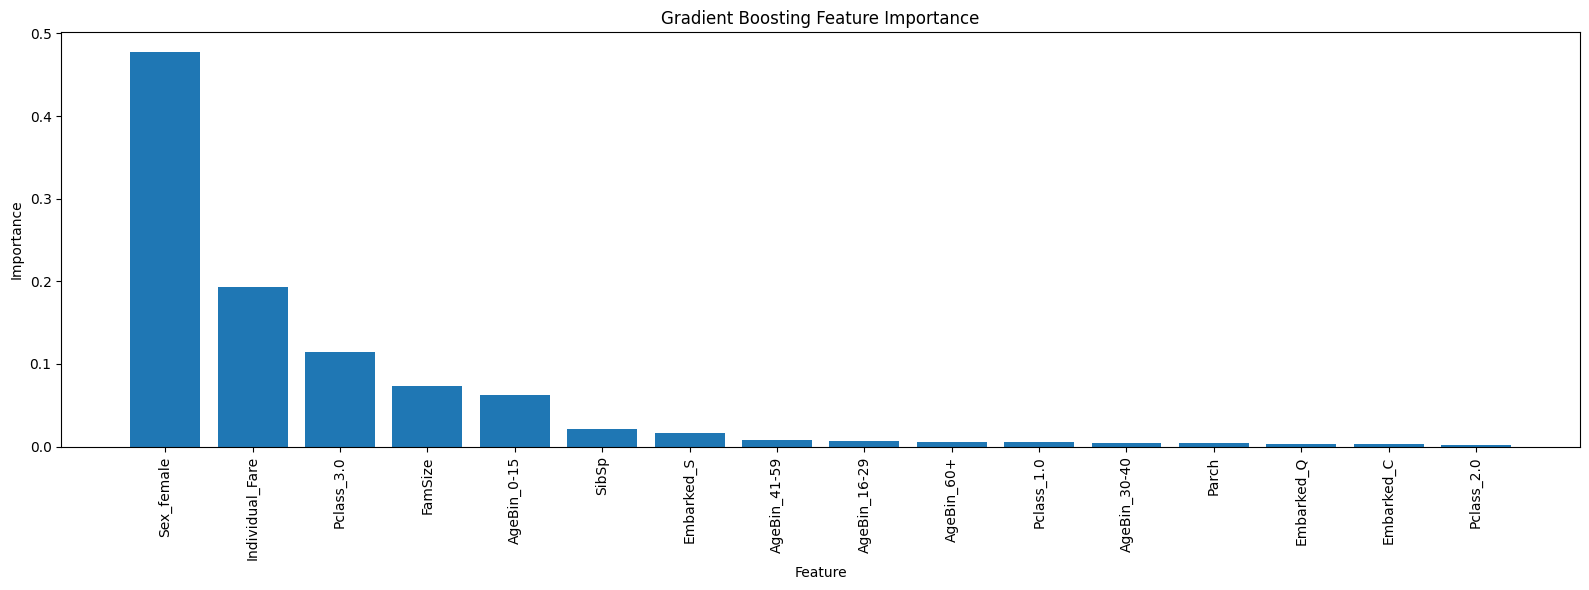

In [ ]:
plot_feature_importance(feature_importance_df)

Let us summarize what our models have to say w.r.t feature importance of each feature

In [ ]:
feature_ranks = {feature: [] for model in feature_importance_df["Feature Names"] for feature in model}

# Populate the feature_ranks dictionary with ranks
for _, row in feature_importance_df.iterrows():
    sorted_features = sorted(zip(row["Feature Names"], row["Mean Feature Importance"]), key=lambda x: x[1], reverse=True)
    for rank, (feature, _) in enumerate(sorted_features, start=1):
        feature_ranks[feature].append(rank)

# Calculate the average rank for each feature
average_ranks = {feature: np.mean(ranks) for feature, ranks in feature_ranks.items()}

# Sort features based on their average rank
sorted_features_by_avg_rank = sorted(average_ranks, key=average_ranks.get)

# Create a dataframe where rows are features and columns are models
# Entries are the rank of each feature in each model
rank_df = pd.DataFrame(index=sorted_features_by_avg_rank, columns=feature_importance_df["Model"])

for model, row in feature_importance_df.iterrows():
    for feature in row["Feature Names"]:
        rank = sorted(zip(row["Feature Names"], row["Mean Feature Importance"]), key=lambda x: x[1], reverse=True).index((feature, row["Mean Feature Importance"][row["Feature Names"].index(feature)])) + 1
        rank_df.at[feature, row["Model"]] = rank
rank_df["Average Rank"] = [average_ranks[feature] for feature in rank_df.index]

rank_df

Model,Random Forest,Decision Tree,XGBoost,Gradient Boosting,Average Rank
Sex_female,2,1,1,1,1.25
Pclass_3.0,4,3,2,3,3.00
Individual_Fare,1,2,10,2,3.75
FamSize,3,4,6,4,4.25
SibSp,5,5,4,6,5.00
AgeBin_0-15,6,6,3,5,5.00
Parch,7,7,8,13,8.75
Embarked_S,10,11,9,7,9.25
Pclass_1.0,8,15,5,11,9.75
AgeBin_16-29,9,8,14,9,10.00


Key takeaways:
*   Gender is key to survival odds, as outlined in the univariate featurea analysis
*   P_class 3.0 in particular seems to be a good predictor of survival odds (in that it decreases them, check the univariate feature analysis)
*   Individual Fare paid appears an important survival predictor, and likely "steals" the positive effects towards survival odds of P_class 1. Interestingly, XGBoost prefers P_class1 over Individual Fare.
*   FamSize, as well as its linear contributors, Parch and SibSp appear overall important, we can consider removing the original Parch and SibSp and only keeping their amalgamation FamSize, although multicollinearity is not that big of an issue for the models at hand.
*   In terms of Age, only the age group 0-15 appears at all relevant in predicting survival odds (again, as postulated earlier in the univariate feature analysis)




It is clear that some variables are more useful than others - but how do we decide what the cut-off point is? Where does the bias-variance tradeoff become too expensive? In order to investigate that we can do the following:

1. Iteratively fit all models with their prefered features, starting with only one feature and adding one feature at a time
2. Utilize cross-validation at each step and report the training and validation accuracy of each model-feature number combination.
3. Plot the training and validation accuracy for each model, observe for which number of features the validation accuracy plateaus or even starts going down.
4. Only retain the n-most important features to the particular model, where n is implied in 3.

To make 1. easier, let us compute a dictionary with model as a key, and features ordered by feature importance according to said model as a value.

In [ ]:
# Constructing the dictionary
feature_importance_dict = {}

for index, row in feature_importance_df.iterrows():
    # Pairing feature names with their importances
    paired_features = list(zip(row["Feature Names"], row["Mean Feature Importance"]))
    # Sorting based on importance
    sorted_features = sorted(paired_features, key=lambda x: x[1], reverse=True)
    # Extracting sorted feature names
    sorted_feature_names = [feature[0] for feature in sorted_features]
    # Adding to dictionary
    feature_importance_dict[row["Model"]] = sorted_feature_names

feature_importance_dict.keys()

dict_keys(['Random Forest', 'Decision Tree', 'XGBoost', 'Gradient Boosting'])

Recall that Logistic Regression, SVM and SGD did not have a feature importance attribute. For their feature order, we will therefore just provide the average feature importance order across our other models.

In [ ]:
# Update feature_importance_dict with models missing in it
for model_name, _ in models:
    if model_name not in feature_importance_dict:
        # The value is a list of features ordered by the average rank
        feature_importance_dict[model_name] = rank_df.index.tolist()

In [ ]:
from sklearn.model_selection import cross_validate
def train_model_iteratively(model, features, X, y, cv=10, random_state=41):
    train_accuracies = []
    val_accuracies = []
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for i in range(len(features)):
        selected_features = features[:i+1]
        X_subset = X[selected_features]

        # Perform cross-validation
        cv_results = cross_validate(model, X_subset, y, cv=cv_strategy, return_train_score=True)
        train_accuracy = np.mean(cv_results['train_score'])
        val_accuracy = np.mean(cv_results['test_score'])

        # Append the accuracies
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    return train_accuracies, val_accuracies

In [ ]:
# Iterating over models
results_iterative_features = {}
for model_name, model_instance in models:
    features = feature_importance_dict[model_name]
    train_accuracies, val_accuracies = train_model_iteratively(model_instance, features, X_train, y_train)
    accuracies = {"train_accuracies": train_accuracies, "val_accuracies": val_accuracies}
    results_iterative_features[model_name] = accuracies

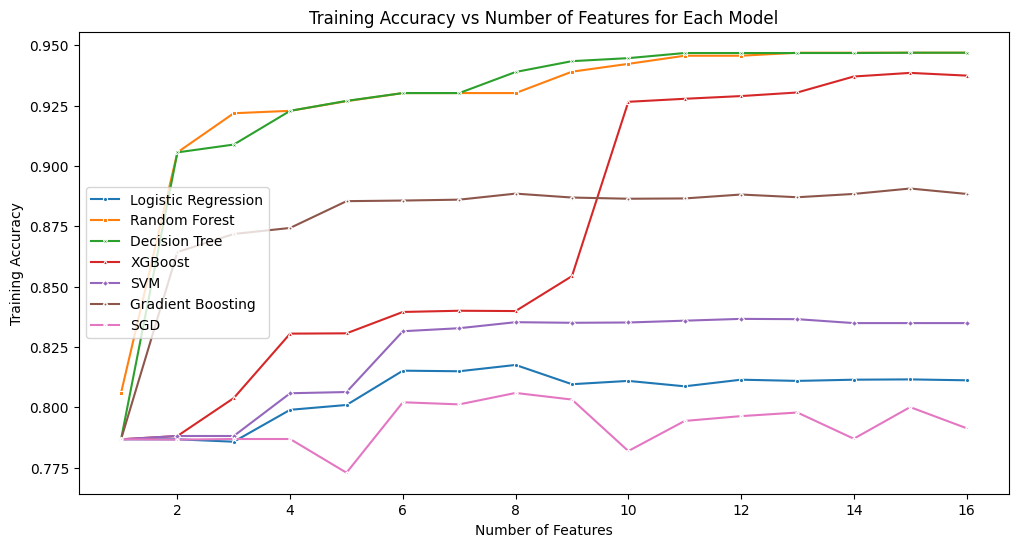

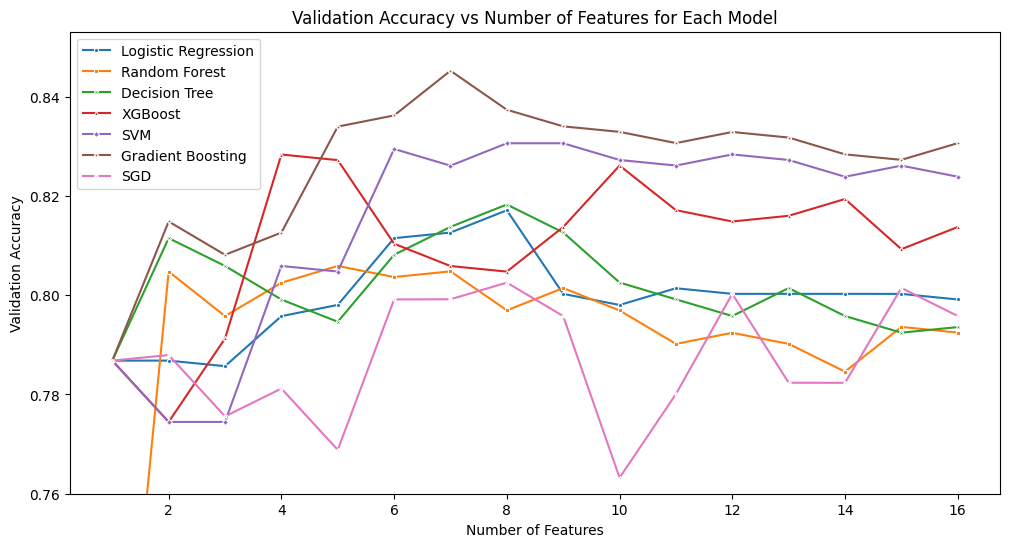

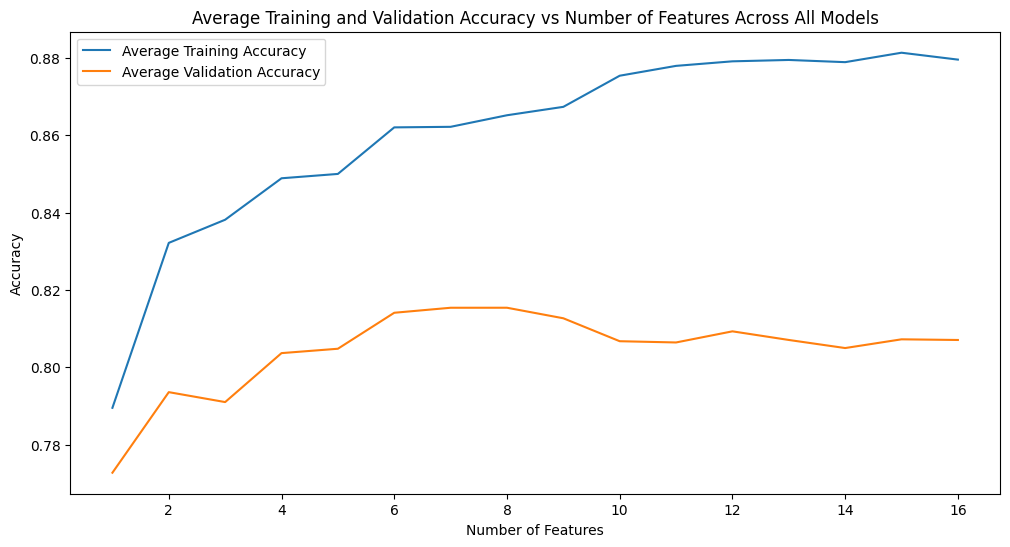

In [ ]:
marker_cycle = ['o', 's', 'X', '^', 'D', 'P', '*', 'H', 'x', '+']
# Train Accuracy for All Models
plt.figure(figsize=(12, 6))
for i, model in enumerate(results_iterative_features):
    sns.lineplot(x=range(1, len(results_iterative_features[model]["train_accuracies"]) + 1),
                 y=results_iterative_features[model]["train_accuracies"],
                 label=model,
                 marker=marker_cycle[i % len(marker_cycle)], # Cycle through markers
                 markersize=3,  # Increase marker size for visibility
                 markerfacecolor='auto')  # Set marker color to match the line
plt.xlabel("Number of Features")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs Number of Features for Each Model")
plt.legend()
plt.show()


# Validation Accuracy for All Models
plt.figure(figsize=(12, 6))
for i, model in enumerate(results_iterative_features):
    sns.lineplot(x=range(1, len(results_iterative_features[model]["val_accuracies"]) + 1),
                 y=results_iterative_features[model]["val_accuracies"],
                 label=model,
                 marker=marker_cycle[i % len(marker_cycle)], # Cycle through markers
                 markersize=3,  # Increase marker size for visibility
                 markerfacecolor='auto')  # Set marker color to match the line)
plt.ylim(bottom = 0.76)
plt.xlabel("Number of Features")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Number of Features for Each Model")
plt.legend()
plt.show()

# Average Train and Validation Accuracy Across All Models
num_features = len(next(iter(results_iterative_features.values()))["train_accuracies"])
average_train_accuracies = [np.mean([results_iterative_features[model]["train_accuracies"][i] for model in results_iterative_features]) for i in range(num_features)]
average_val_accuracies = [np.mean([results_iterative_features[model]["val_accuracies"][i] for model in results_iterative_features]) for i in range(num_features)]

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, num_features + 1), y=average_train_accuracies, label="Average Training Accuracy")
sns.lineplot(x=range(1, num_features + 1), y=average_val_accuracies, label="Average Validation Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Average Training and Validation Accuracy vs Number of Features Across All Models")
plt.legend()
plt.show()

We can make our choices for number of feature for each model based on the second plot. In making our choice, we largely have two possible approaches:

1.Select the number of features with the absolute highest validation accuracy: This approach prioritizes the performance of the respective model. However, it might also lead to a model more prone to overfitting, especially if the increase in accuracy is marginal.

2.Selecting a slightly lower number of features close to maximum validation accuracy: By choosing a number of features that provides accuracy close to the maximum but with significantly fewer features, we would obtain a simpler, more interpretable model that is potentially less prone to overfitting. The trade-off here is a slight decrease in accuracy for a potentially more robust and generalizable model.

For our implementation, we will follow the second approach, defining "close to maximum validation accuracy" as "within 0.3%".

In [ ]:
# Function to find the index of the earliest element within eta of the max element in a list
def find_earliest_close_to_max(data, eta):
    max_val = max(data)
    threshold = max_val - eta
    for i, val in enumerate(data):
        if val >= threshold:
            return i
    return None

# Processing each model's validation accuracies
earliest_number_features = {}
eta = 0.003
for model, accuracies in results_iterative_features.items():
    val_accuracies = accuracies['val_accuracies']
    average_val_accuracies = [np.mean([results_iterative_features[model]["val_accuracies"][i] for model in results_iterative_features]) for i in range(num_features)]
    index = find_earliest_close_to_max(val_accuracies, eta = eta)
    earliest_number_features[model] = index +1
print("Smallest number of features that comes within","{:.1%}".format(eta),"of best validation accuracy\nAverage over all models:",find_earliest_close_to_max(average_val_accuracies, eta = 0.003))
earliest_number_features

Smallest number of features that comes within 0.30% of best validation accuracy
Average over all models: 5


{'Logistic Regression': 8,
 'Random Forest': 2,
 'Decision Tree': 8,
 'XGBoost': 4,
 'SVM': 6,
 'Gradient Boosting': 7,
 'SGD': 8}

In [ ]:
# Creating a new dictionary to store the top features for each model based on the optimum number of features
final_features_by_model = {}
final_features_averaged = {}
for model, n_features in earliest_number_features.items():
    final_features_by_model[model] = feature_importance_dict[model][:n_features]

final_features_by_model
final_features_averaged["Average"] =  rank_df.index.tolist()[:find_earliest_close_to_max(average_val_accuracies, eta = 0.003)]

###Hyperparameter tuning

In [ ]:
# Helper function we will use for Bayesian hyperparameter tuning,
# reports negative acurracy as a loss metric needed for Trials
def objective(params, model_cls, features, X, y, random_state):
    if params.get('penalty') == 'none':
      params['C'] = 1.0  # Reset C to its default value when penalty is None
    clf = model_cls(**params)
    cv_results = cross_validate(
        clf, X[features], y,
        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state),
        return_train_score=True, scoring='accuracy'
    )
    clf.fit(X[features], y)  # Refit with all data
    mean_train_score = np.mean(cv_results['train_score'])
    mean_val_score = np.mean(cv_results['test_score'])

    return {'loss': -mean_val_score, 'status': STATUS_OK, 'mean_train_score': mean_train_score, "model": clf}


def tune_model_hyperparameters(models, spaces, X, y, features_by_model,
                               cv_folds=10, max_evals=100, random_state=41,
                               method="GridSearch"):
    best_params, best_models, best_scores = {}, {}, {}

    for model_name, model_cls in models:
        print(f"Tuning hyperparameters for {model_name}...")
        features = features_by_model[model_name]
        space = spaces[model_name]

        if method == "Bayesian":

            trials = Trials()
            best = fmin(
                fn=lambda params: objective(params, model_cls, features, X, y, random_state),
                space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials
            )

            best_params[model_name] = best
            best_trial = min(trials.trials, key=lambda x: x['result']['loss'])
            best_model = best_trial['result']['model']
            train_score = best_trial['result']['mean_train_score']
            val_score = -best_trial['result']['loss']

        elif method == "GridSearch":
            grid_search = GridSearchCV(model_cls(), space, cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state), scoring='accuracy', n_jobs=-1, return_train_score=True)
            grid_search.fit(X[features], y)

            best_params[model_name] = grid_search.best_params_
            best_model = grid_search.best_estimator_
            train_score = grid_search.cv_results_['mean_train_score'][grid_search.best_index_]
            val_score = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]

        else:
            raise ValueError("Method must be 'Bayesian' or 'GridSearch'.")

        best_models[model_name] = best_model
        best_scores[model_name] = {'mean_train_score': train_score, 'mean_val_score': val_score}
        print(f"Best parameters for {model_name}: {best_params[model_name]}")
        print(f"Mean training score: {train_score}, Mean validation score: {val_score}")

    return best_params, best_models, best_scores

####Bayesian

Now that we have exhausted our data-centric options, we turn to hyperparameter tuning. We define the following parameter spaces:

In [ ]:
from hyperopt import hp
space_lr = {
    'C': hp.loguniform('C_lr', np.log(0.001), np.log(100)),
    'penalty': hp.choice('penalty_lr', ['l2', 'none']),  # 'l1' and 'elasticnet' might require solver adjustment
    'solver': hp.choice('solver_lr', ['lbfgs', 'saga'])  # 'saga' supports 'l1' and 'elasticnet'

}
space_rf = {
    'n_estimators': hp.choice('n_estimators_rf', [100, 200, 300, 400]),
    'max_depth': hp.choice('max_depth_rf', [None, 5, 10, 15]),
    'min_samples_split': hp.choice('min_samples_split_rf', [2, 4, 6])
}
space_dt = {
    'max_depth': hp.choice('max_depth_dt', [None, 5, 10, 15]),
    'min_samples_split': hp.choice('min_samples_split_dt', [2, 4, 6]),
    'criterion': hp.choice('criterion_dt', ['gini', 'entropy'])
}
space_xgb = {
     "objective": hp.choice('objective_xgb', ["binary:logistic", "another_objective"]),
    'learning_rate': hp.uniform('learning_rate_xgb', 0.01, 0.3),
    'max_depth': hp.choice('max_depth_xgb', [3, 5, 7, 9]),
    'n_estimators': hp.choice('n_estimators_xgb', [100, 200, 300]),
    'subsample': hp.uniform('subsample_xgb', 0.7, 1)
}
space_svm = {
    'C': hp.loguniform('C_svm', np.log(0.01), np.log(100)),
    'kernel': hp.choice('kernel_svm', ['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': hp.choice('gamma_svm', [0.1, 1, 'scale', 'auto'])
}
space_gb = {
    'learning_rate': hp.uniform('learning_rate_gb', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators_gb', [100, 200, 300]),
    'max_depth': hp.choice('max_depth_gb', [3, 5, 8])
}
space_sgd = {
    'alpha': hp.loguniform('alpha_sgd', np.log(0.0001), np.log(0.1)),
    'penalty': hp.choice('penalty_sgd', ['l2', 'l1', 'elasticnet']),
    'learning_rate': hp.choice('learning_rate_sgd',
     ['constant', 'optimal', 'invscaling', 'adaptive']),
    'eta0': hp.loguniform('eta0_sgd', np.log(0.01), np.log(1))  # Only used if learning_rate is 'constant' or 'invscaling'
}
spaces = {
    'Logistic Regression': space_lr,
    'Random Forest': space_rf,
    'Decision Tree': space_dt ,
    "XGBoost": space_xgb,
    'SVM': space_svm,
    'Gradient Boosting': space_gb,
    'SGD': space_sgd
}

In [ ]:
# Suppress FutureWarnings from sklearn, else you get spammed
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')

models = [
    ('Logistic Regression', LogisticRegression),
    ('Random Forest', RandomForestClassifier),
    ('Decision Tree', DecisionTreeClassifier),
    ('XGBoost', XGBClassifier),
    ('SVM', SVC),
    ('Gradient Boosting', GradientBoostingClassifier),
    ('SGD', SGDClassifier)
]
method = "Bayesian"
best_hyperparameters, best_models, best_scores = tune_model_hyperparameters(models, spaces, X_train, y_train, final_features_by_model, method = method)

Tuning hyperparameters for Logistic Regression...
100%|██████████| 100/100 [00:15<00:00,  6.27trial/s, best loss: -0.8171285892634206]
Best parameters for Logistic Regression: {'C_lr': 0.7876871830963899, 'penalty_lr': 0, 'solver_lr': 1}
Mean training score: 0.816935190114601, Mean validation score: 0.8171285892634206
Tuning hyperparameters for Random Forest...
100%|██████████| 100/100 [11:39<00:00,  7.00s/trial, best loss: -0.8115230961298376]
Best parameters for Random Forest: {'max_depth_rf': 2, 'min_samples_split_rf': 0, 'n_estimators_rf': 1}
Mean training score: 0.899115351446602, Mean validation score: 0.8115230961298376
Tuning hyperparameters for Decision Tree...
100%|██████████| 100/100 [00:08<00:00, 11.77trial/s, best loss: -0.8384769038701622]
Best parameters for Decision Tree: {'criterion_dt': 0, 'max_depth_dt': 2, 'min_samples_split_dt': 2}
Mean training score: 0.9088430608871081, Mean validation score: 0.8384769038701622
Tuning hyperparameters for XGBoost...
100%|█████████

In [ ]:
best_hyperparameters["XGBoost"]['objective'] = 'binary:logistic'

####GridSearch

In [ ]:
grid_lr = {
    'C': np.logspace(-3, 2, num=6),  # log space between 0.001 and 100
    'penalty': ['l2', 'none'],
    'solver': ['lbfgs', 'saga']
}
grid_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6]
}
grid_dt = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6],
    'criterion': ['gini', 'entropy']
}
grid_xgb = {
     "objective": ["binary:logistic"],
    'learning_rate': np.linspace(0.01, 0.3, num=6),
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300],
    'subsample': np.linspace(0.7, 1.0, num=4)
}
grid_svm = {
    'C': np.logspace(-2, 2, num=5),  # log space between 0.01 and 100
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.1, 1, 'scale', 'auto']
}
grid_gb = {
    'learning_rate': np.linspace(0.01, 0.3, num=6),
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 8]
}
grid_sgd = {
    'alpha': np.logspace(-4, -1, num=4),
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': np.logspace(-2, 0, num=3)  # log space between 0.01 and 1
}
spaces = {
    'Logistic Regression': grid_lr,
    'Random Forest': grid_rf,
    'Decision Tree': grid_dt,
    'XGBoost': grid_xgb,
    'SVM': grid_svm,
    'Gradient Boosting': grid_gb,
    'SGD': grid_sgd
}


In [ ]:
# Define your models
models = [
    ('Logistic Regression', LogisticRegression),
    ('Random Forest', RandomForestClassifier),
    ('Decision Tree', DecisionTreeClassifier),
    ('XGBoost', XGBClassifier),
    ('SVM', SVC),
    ('Gradient Boosting', GradientBoostingClassifier),
    ('SGD', SGDClassifier)
]
method = "GridSearch"
# Assuming grid_spaces and features_by_model are already defined as per your previous message
best_hyperparameters, best_models, best_scores = tune_model_hyperparameters(models, spaces, X_train, y_train, final_features_by_model, method = method)

Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Mean training score: 0.8175587871768768, Mean validation score: 0.8171285892634206
Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Mean training score: 0.8987411309429298, Mean validation score: 0.8103995006242197
Tuning hyperparameters for Decision Tree...
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 6}
Mean training score: 0.9088430608871081, Mean validation score: 0.8373782771535578
Tuning hyperparameters for XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300, 'objective': 'binary:logistic', 'subsample': 0.7999999999999999}
Mean training score: 0.830528547544995, Mean validation score: 0.8294881398252183
Tuning hyperparameters for SVM...
Best parameters for S

In [ ]:
best_hyperparameters["XGBoost"]['objective'] = 'binary:logistic'

###Ensembling

In [ ]:
for model_name, model in best_models.items():
    model_features = final_features_by_model[model_name]
    model.fit(X_train[model_features], y_train)

smaller_models = {}

for model_name, model in best_models.items():
    smaller_model = clone(model)  # Clone the original model
    smaller_model.fit(X_train[final_features_averaged["Average"]], y_train)
    smaller_models[model_name] = smaller_model

voting_clf = VotingClassifier(estimators=[(name, model) for name, model in smaller_models.items()], voting='hard')
voting_clf.fit(X_train[final_features_averaged["Average"]], y_train)

stacking_clf = StackingClassifier(estimators=[(name, model) for name, model in smaller_models.items()])
stacking_clf.fit(X_train[final_features_averaged["Average"]], y_train)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model_scores = {}
small_model_scores = {}
# Evaluate each individual model
for model_name, model in best_models.items():
    model_features = final_features_by_model[model_name]
    cv_results = cross_validate(model, X_train[model_features], y_train, cv=cv, scoring='accuracy', return_train_score=True)
    model_scores[model_name] = {
        'mean_train_score': np.mean(cv_results['train_score']),
        'mean_val_score': np.mean(cv_results['test_score'])
    }
for model_name, smaller_models in best_models.items():
    cv_results = cross_validate(smaller_model, X_train[final_features_averaged["Average"]], y_train, cv=cv, scoring='accuracy', return_train_score=True)
    small_model_scores[model_name] = {
        'mean_train_score_small_features': np.mean(cv_results['train_score']),
        'mean_val_score': np.mean(cv_results['test_score'])
    }

# Evaluate the hard voting classifier
voting_cv_results = cross_validate(voting_clf, X_train, y_train, cv=cv, scoring='accuracy', return_train_score=True)
model_scores['Hard Voting Classifier'] = {
    'mean_train_score': np.mean(voting_cv_results['train_score']),
    'mean_val_score': np.mean(voting_cv_results['test_score'])
}

# Evaluate the stacking classifier
stacking_cv_results = cross_validate(stacking_clf, X_train, y_train, cv=cv, scoring='accuracy', return_train_score=True)
model_scores['Stacking Classifier'] = {
    'mean_train_score': np.mean(stacking_cv_results['train_score']),
    'mean_val_score': np.mean(stacking_cv_results['test_score'])
}

# Print the scores
for model_name, scores in model_scores.items():
    print(f"{model_name} - Mean Training Accuracy: {scores['mean_train_score']}, Mean Validation Accuracy: {scores['mean_val_score']}")


Logistic Regression - Mean Training Accuracy: 0.8170592557308352, Mean Validation Accuracy: 0.811398252184769
Random Forest - Mean Training Accuracy: 0.8984912873870256, Mean Validation Accuracy: 0.8092009987515605
Decision Tree - Mean Training Accuracy: 0.9102129196359912, Mean Validation Accuracy: 0.8170786516853932
XGBoost - Mean Training Accuracy: 0.8305273022188597, Mean Validation Accuracy: 0.8271410736579277
SVM - Mean Training Accuracy: 0.8312754318946703, Mean Validation Accuracy: 0.8293632958801498
Gradient Boosting - Mean Training Accuracy: 0.8958723665243882, Mean Validation Accuracy: 0.8361423220973782
SGD - Mean Training Accuracy: 0.7959846015423364, Mean Validation Accuracy: 0.7890012484394507
Hard Voting Classifier - Mean Training Accuracy: 0.9065971152020074, Mean Validation Accuracy: 0.8170661672908863
Stacking Classifier - Mean Training Accuracy: 0.895499858344152, Mean Validation Accuracy: 0.8226466916354557


In [ ]:
# Finding the model with the highest validation accuracy
best_model_name = max(model_scores, key=lambda k: model_scores[k]['mean_val_score'])

In [ ]:
if best_model_name in best_models:
    # If it's an individual model
    best_model = best_models[best_model_name]
    best_features = final_features_by_model[best_model_name]
    best_model.fit(X_train[best_features], y_train)
    test_predictions = best_model.predict(X_test[best_features])
else:
    # If it's an ensemble method
    if best_model_name == 'Hard Voting Classifier':
        # Create and fit the hard voting classifier
        voting_clf = VotingClassifier(estimators=[(name, best_models[name]) for name in best_models], voting='hard')
        voting_clf.fit(X_train[final_features_averaged['Average']], y_train)
        test_predictions = voting_clf.predict(X_test[final_features_averaged['Average']])
    elif best_model_name == 'Stacking Classifier':
        # Create and fit the stacking classifier
        stacking_clf = StackingClassifier(estimators=[(name, best_models[name]) for name in best_models])
        stacking_clf.fit(X_train[final_features_averaged['Average']], y_train)
        test_predictions = stacking_clf.predict(X_test[final_features_averaged['Average']])


In [ ]:
output = pd.DataFrame({"PassengerId":test_PassengerId,"Survived":test_predictions})
output.to_csv("/content/drive/MyDrive/Kaggle/titanic/submission5.csv", index = False)